# Optimizador momentum

El optimizador de descenso por gradiente con momento es una variante del descenso por gradiente tradicional que ayuda a acelerar el entrenamiento de modelos, especialmente en superficies de error que son muy poco profundas o con curvaturas irregulares. La idea es tomar en cuenta los gradientes anteriores para determinar la dirección de la actualización en cada paso, lo que permite al método "acumular velocidad" en direcciones consistentes y suavizar las actualizaciones en direcciones variables.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import nni


## Problema

La función de Beale es una conocida función de prueba en optimización matemática utilizada para evaluar y comparar el rendimiento de algoritmos de optimización. Esta función se usa comúnmente en pruebas de algoritmos debido a sus múltiples mínimos locales y un mínimo global, lo que la hace un desafío interesante para los algoritmos de optimización.

$$
f(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2
$$

Características de la función de Beale:
- Mínimo global: La función tiene un mínimo global en el punto $(3,0.5)$ con un valor de $f(x,y)=0$.
- Mínimos locales: La función tiene varios mínimos locales, lo que la convierte en un desafío para los algoritmos de optimización que buscan el mínimo global.
- Superficie compleja: La superficie de la función es bastante compleja, lo que permite evaluar la capacidad de los algoritmos de optimización.



In [21]:
problem = nni.BealeProblem()

x = np.linspace(problem.min_x, problem.max_x, 100)
y = np.linspace(problem.min_y, problem.max_y, 100)

# Create a meshgrid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the corresponding z values using the function f
Z = problem.function(X, Y)
# Applying a logarithmic transformation to Z values
Z_log = np.log(Z + 1)  # Adding 1 to avoid taking log of zero

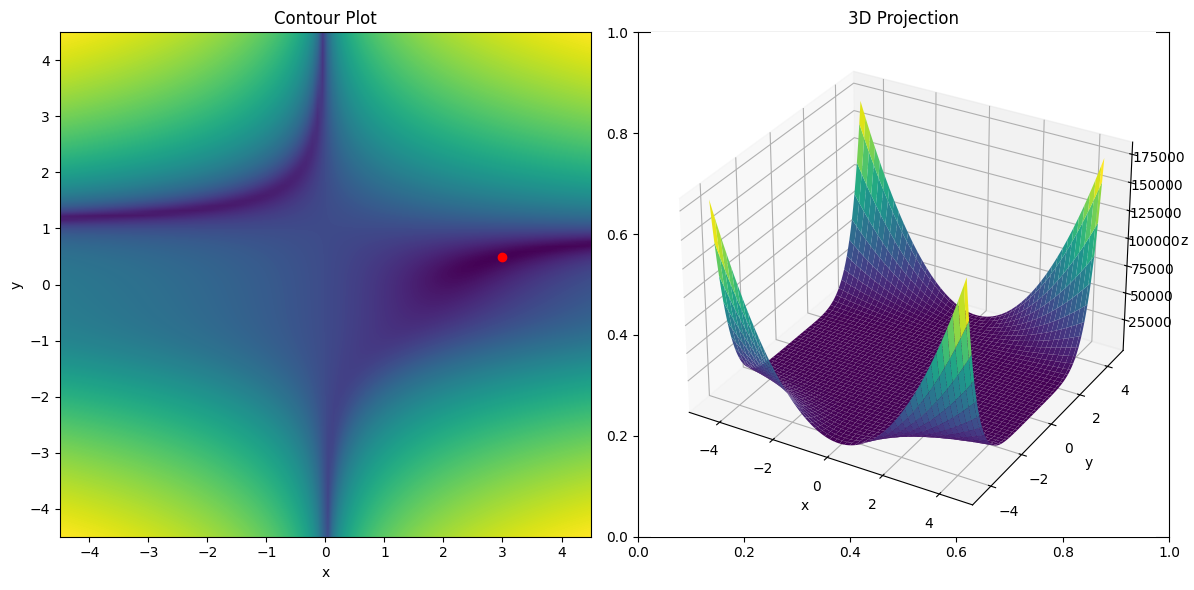

In [4]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the contour plot in the first subplot
ax1.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
ax1.plot(problem.optimal_params[0], problem.optimal_params[1], 'ro')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Contour Plot')

# Plot the 3D projection in the second subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('3D Projection')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [22]:
class MomentumOptimizer(nni.GradientDescentOptimizer):
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6, beta=0.9):
        super().__init__(learning_rate=learning_rate, max_iterations=max_iterations, tolerance=tolerance)
        self.beta = beta
        self.momentum = np.zeros(2) # TODO: initialize dinamically
        self.name = 'Momentum'

    def next_params(self, gradient, params):
        self.momentum = [self.beta * m + (1 - self.beta) * grad for m, grad in zip(self.momentum, gradient)]
        return [param - self.learning_rate * mom for param, mom in zip(params, self.momentum)]

In [23]:
# -- hyperparameters --
# Initial guess
initial_params = [-1.25, 2.5]
# Learning rate
learning_rate = 0.005
# Maximum number of iterations
max_iterations = 500
# beta for momentum
beta = 0.9

In [24]:
optimizer = MomentumOptimizer(learning_rate=learning_rate, max_iterations=max_iterations, tolerance=1e-6, beta=beta)    

# Optimize the function
optimized_params = optimizer.optimize(problem.function, lambda x, y: [problem.gradient_x(x, y), problem.gradient_y(x, y)], initial_params)

print(f'Parámetros optimizados: {optimized_params}')
print(f'Mejor valor encontrado: {problem.function(*optimized_params)}')

Parámetros optimizados: [2.6141876736446727, 0.3858704327604824]
Mejor valor encontrado: 0.037671417674554154


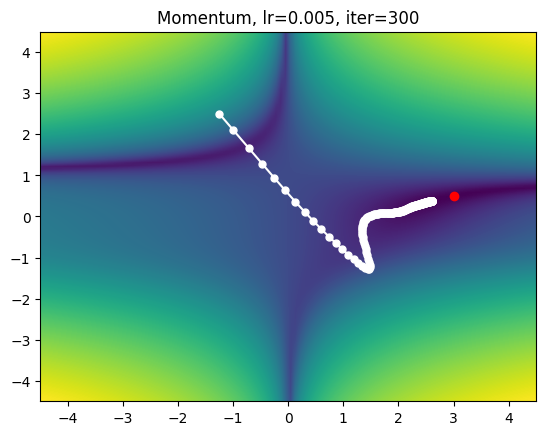

In [25]:
# Extract the x and y values from the history variable
history = optimizer.get_history()
x_values = [log['params'][0] for log in history]
y_values = [log['params'][1] for log in history]

# Create a 2D plot of the function
plt.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
plt.plot(problem.optimal_params[0], problem.optimal_params[1], 'ro')
plt.plot(x_values, y_values, 'w.-', markersize=10)
plt.title(f'{optimizer.name}, lr={optimizer.learning_rate}, iter={len(history)}')
plt.show()

In [26]:
#Animate and save the optimization process
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
points = ax.scatter(x_values[0], y_values[0], c='w', s=10)

# Function to update the plot for each frame
def update(frame):
    # Clear the previous plot
    ax.cla()
    
    # Create a new contour plot
    contour = ax.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
    plt.plot(problem.optimal_params[0], problem.optimal_params[1], 'ro')
    if frame > 0:
        # Plot the optimization path
        points = ax.plot(x_values[:frame], y_values[:frame], 'w.-', markersize=10)
    else:
        points = ax.scatter(x_values[:frame], y_values[:frame], c='w', s=10)
    # Update the title for each frame
    ax.set_title(f'{optimizer.name} lr = {optimizer.learning_rate}, iter {frame}/{len(x_values)}')

    return (contour, points)
    
# Create the animation
animation.FuncAnimation(fig, update, frames=len(x_values), interval=30).save('gradient_descent.mp4')